In [2]:
import numpy as np
from scipy.sparse import csr_matrix

In [3]:
import numpy as np
import torch
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import random
class DataPipeline(Dataset):
    def __init__(self, filename,window_size = 7,min_freq=5,vocab=None,neg_words=5):
        self.data = self.read_data(filename)
        self.neg_words = neg_words
        self.window_size = window_size
        if vocab is None:
            self.vocab, self.ind2vocab,self.word_count = self.build_vocab(self.data,min_freq)
        else:
            self.vocab = vocab
            self.ind2vocab = {v: k for k, v in vocab.items()}
            self.word_count = self.get_word_count(vocab,self.data,min_freq)
        self.neg_sampling_table = self.__create_neg_sampling_table()
        self.sub_sampling_table = self.__create_sub_sampling_table()

    def get_vocab(self):
        return self.vocab
    
    @staticmethod
    def read_data(filename):
        data = []
        with open(filename, 'r') as f:
            for line in f.readlines():
                e = line.strip()
                data.append(e.split())
        return data
    
    def get_word_count(self,vocab,data):
        word_count = {0: 0}
        for line in data:
            for word in line:
                if word in vocab:
                    word_count[vocab[word]] += 1
                else:
                    word_count[0] += 1
        return word_count
    
    def most_common(self,n):
        counter = Counter(self.word_count)
        common = counter.most_common(n)
        ind_freq = dict(common)
        # convert to word frequency
        word_freq = {}
        for ind in ind_freq:
            word_freq[self.ind2vocab[ind]] = ind_freq[ind]
        return word_freq
    
    @staticmethod
    def build_vocab(data,min_freq=10):
        word_set = {}
        for line in data:
            for word in line:
                if word not in word_set:
                    word_set[word]=1
                else:
                    word_set[word]+=1
        # sort the vocab
        word_list = sorted(list(word_set))
        word_count = {0: 1}
        vocab_dict = {"<unk>": 0}
        i=1
        for word in word_list:
            if word_set[word] >= min_freq:
                vocab_dict[word] = i
                word_count[i] = word_set[word]
                i+=1
            else:
                word_count[0] += word_set[word]
        ind2word = {v: k for k, v in vocab_dict.items()}
        return vocab_dict, ind2word, word_count

    def total_count(self):
        return sum(self.word_count.values())

    
    def __create_sub_sampling_table(self, threshold=1e-5):
        word_freq = np.array(list(self.word_count.values()))
        word_freq = word_freq / np.sum(word_freq)
        sub_sampling_table = ((np.sqrt(word_freq / threshold) + 1) * (threshold / word_freq))
        return sub_sampling_table
    
    def is_sample_selected(self, idx):
        # return True if the word is selected
        return random.random() < self.sub_sampling_table[idx]
    
    def __create_neg_sampling_table(self, power=0.75, table_size =1e8):
        vocab_size = len(self.vocab)
        word_freq = np.array(list(self.word_count.values())) ** power
        word_freq = word_freq / np.sum(word_freq)
        count = np.round(word_freq * table_size)
        neg_sampling_table = []
        for i in range(vocab_size):
            neg_sampling_table += [i] * int(count[i])
        neg_sampling_table = np.array(neg_sampling_table)
        np.random.shuffle(neg_sampling_table)
        return neg_sampling_table.tolist()
    
    def get_negative_samples(self, target, k):
        delta = random.sample(self.neg_sampling_table, k)
        while target in delta:
            delta = random.sample(self.neg_sampling_table, k)
        return delta   

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words = self.data[idx]
        data = []
        start = self.window_size // 2
        for i in range(start, len(words) - start):
            if words[i] not in self.vocab or not self.is_sample_selected(self.vocab[words[i]]):
                continue
            target = self.vocab[words[i]]
            context = words[i - start: i] + words[i + 1: i + start + 1]
            #convert words to indices and unknown words to 0
            context = [ self.vocab[word] if word in self.vocab else self.vocab["<unk>"] for word in context ]
            neg_samples = self.get_negative_samples(target, self.neg_words)
            data.append((target, context, neg_samples))
        return data
    
    def __collate_fn(self,batches):
        target = []
        context = []
        neg_samples = []
        for sentence in batches:
            for t,c,n in sentence:
                target.append(t)
                context.append(c)
                neg_samples.append(n)
        return torch.LongTensor(target),torch.LongTensor(context),torch.LongTensor(neg_samples)

    def get_batches(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=False,collate_fn=self.__collate_fn ,drop_last=True)


In [4]:
data = DataPipeline.read_data('../data/processed_data/corpus_cleaned.txt')

In [5]:
vocab, ind2vocab, word_count = DataPipeline.build_vocab(data)

In [6]:
len(vocab)

23522

In [23]:
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.decomposition import TruncatedSVD

In [32]:
class SVD_W2V:
    def __init__(self, vocab, window,embedding_size):
        self.dim = len(vocab)
        self.vocab = vocab
        self.window_size = window
        self.embedding_size = embedding_size
        self.cooccurrence_matrix = np.zeros((self.dim, self.dim))

    def train(self,data):
        self.__build_cooccurrence_matrix(data)
        svd = TruncatedSVD(n_components=self.embedding_size, random_state=42)
        self.embeddings = svd.fit_transform(self.cooccurrence_matrix)



    def __build_cooccurrence_matrix(self, data):
        self.cooccurrence_matrix = np.zeros((self.dim, self.dim))
        for tokens in data:
            for pos,token in enumerate(tokens):
                if token not in self.vocab:
                    continue
                start = max(0, pos - self.window_size)
                end = min(len(tokens), pos + self.window_size)
                for context_pos in range(start, end):
                    if context_pos != pos:
                        context_token = tokens[context_pos]
                        if context_token in self.vocab:
                            self.cooccurrence_matrix[self.vocab[token], self.vocab[context_token]] += 1
                        else:
                            self.cooccurrence_matrix[self.vocab[token], self.vocab["<unk>"]] += 1
        self.cooccurrence_matrix = csr_matrix(self.cooccurrence_matrix)
    
    def save_embeddings(self, path):
        with open(path, 'w') as f:
            f.write('{} {}\n'.format(self.dim, self.embedding_size))
            for word, i in self.vocab.items():
                e = ' '.join(map(str, self.embeddings[i]))
                f.write('{} {}\n'.format(word, e))

In [33]:
model = SVD_W2V(vocab, 3,300)

In [34]:
model.cooccurrence_matrix.shape

(23522, 23522)

In [35]:
model.train(data)

In [20]:
model.cooccurrence_matrix[vocab['a'],vocab['movie']]

11165.0

In [22]:
model.cooccurrence_matrix[vocab['shawshank'],vocab['redemption']]

645.0

In [36]:
model.embeddings.shape

(23522, 300)

In [26]:
# model.embeddings = svd.fit_transform(model.cooccurrence_matrix)

In [31]:
model.embeddings[vocab['shawshank']]

array([ 4.75978967e+02, -1.89228277e+02,  1.41338223e+02, -8.74489603e+01,
        8.39868997e+00, -2.98265563e+01, -4.03671266e+01, -3.64086751e+00,
       -1.29764494e+01, -2.84776754e+01,  8.55508636e+01,  4.32625415e+01,
       -3.30878912e+01, -1.70645578e+01,  6.97754943e+00,  1.89698998e+01,
        4.58149934e+00, -1.98645098e+01, -2.46105796e+01,  6.87050059e+01,
        1.23511085e+01,  4.19465163e+01, -4.56533724e+01,  2.34959318e+01,
       -9.00818653e+00, -4.67852696e+00,  4.17646996e+00,  2.52830043e+00,
       -3.40492765e+01, -1.23039374e+00,  1.03964845e+01, -2.40508047e+01,
        2.39372055e+01,  2.47528864e+01, -2.62522459e+00,  9.48995278e-01,
        1.66798898e+01, -1.24240796e+00,  5.41840972e+00, -5.12809831e+00,
        7.39553929e+00,  5.33584436e+00,  1.10615175e+01,  8.67823832e+00,
       -3.05383533e+00,  8.10027405e-01,  7.47609374e+00,  2.60201064e+01,
        1.30265180e+01,  3.53333163e+00, -8.18305275e-01, -1.28785080e+01,
        1.80533394e+01, -

In [40]:
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [47]:
def plot_top10_words(word, model,ind2vocab):
    word = word.lower()
    vocab

    def tsne_plot(results):
        words = []
        embeds = []

        for res in results:
            embeds.append(res[1])
            words.append(res[0])
        
        tsne_model = TSNE(init='pca')
        res_embeds = tsne_model.fit_transform(embeds)

        x_axis_val = []
        y_axis_val = []
        for val in res_embeds:
            x_axis_val.append(val[0])
            y_axis_val.append(val[1])
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis_val)):
            plt.scatter(x_axis_val[i],y_axis_val[i])
            plt.annotate(words[i],
                        xy=(x_axis_val[i],y_axis_val[i]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
        plt.savefig("../figures/svd/"+word+".png")
        #plt.show()
    
    word_index = model.vocab[word]
    word_embed = model.embeddings[word_index]
    res = {}
    for i, embed in tqdm(enumerate(model.embeddings)):
        if i!=word_index:
            res[i] = [1 - cosine(model.embeddings[i], word_embed), model.embeddings[i]]


    results = []
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([ind2vocab[t[0]], t[1][1]])

    print('Word:-', word)
    print('Words:-', end='\t')
    for res in results:
        print(res[0], end=', ')
    print()

    tsne_plot(results)

0it [00:00, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
23522it [00:00, 27762.22it/s]
/home/soumodiptab/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/soumodiptab/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Word:- movie
Words:-	<unk>, moive, film, video, item, product, review, album, program, boxset, 


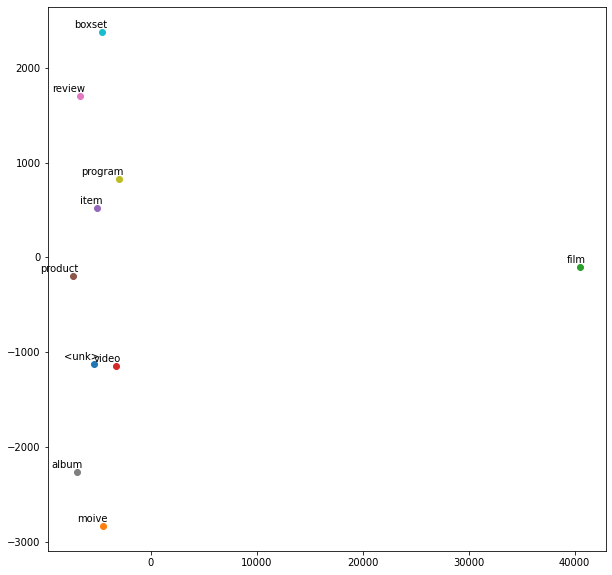

In [52]:
plot_top10_words('movie', model,ind2vocab)

0it [00:00, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
23522it [00:01, 20278.71it/s]
/home/soumodiptab/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/soumodiptab/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Word:- redemption
Words:-	<unk>, plot, dialogue, pacing, dialog, music, soundtrack, ending, beast, casting, 


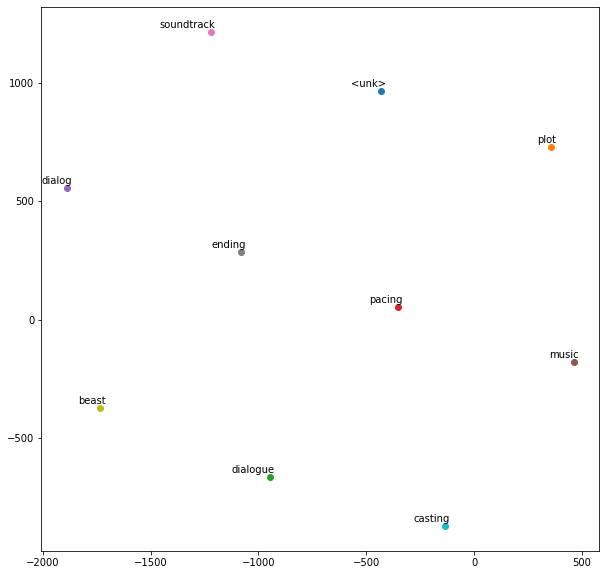

In [50]:
plot_top10_words('redemption', model,ind2vocab)

0it [00:00, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
23522it [00:00, 27077.21it/s]
/home/soumodiptab/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/soumodiptab/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Word:- bad
Words:-	<unk>, horrible, terrible, cliche, obviously, weird, crazy, lame, fake, merely, 


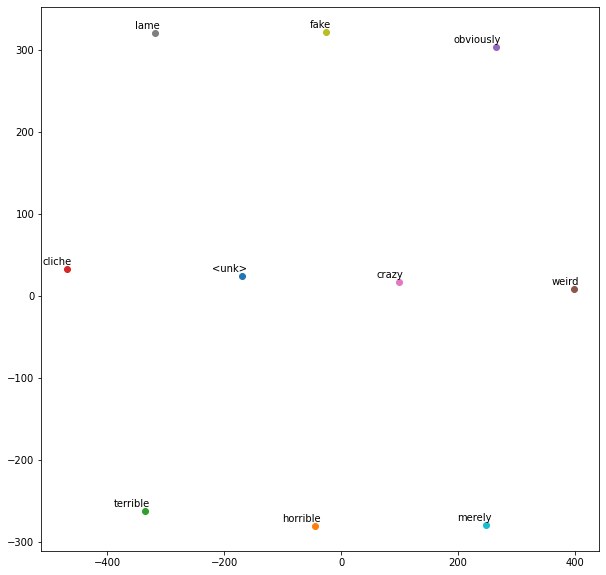

In [51]:
plot_top10_words('bad', model,ind2vocab)